In [ ]:
import numpy as np
import csv
import datetime
import time

In [ ]:
def addElement(array, index, ele):
    if array and index < len(array):
        array[index] += ele
        return array
    newArray = [0] * (index + 1)
    if array:
        newArray[:len(array)] = array
    newArray[index] = ele
    return newArray

In [ ]:
trafficRecordsById = {}
startTime = 1433142000

with open("new.csv") as f:
    trafficRecords = csv.reader(f, delimiter=',')
    count = 0
    for trafficRecord in trafficRecords:
        if count % 100000 == 0:
            print (count / 24015249 * 100, "%")
#         if count == 30000:
#             break
        recordTime = trafficRecord[1]
        checkPointId = trafficRecord[2]
        lane = int(trafficRecord[3])
        traffic = int(trafficRecord[4])

        relativeTime = time.mktime(datetime.datetime.strptime(recordTime, "%Y-%m-%d %H:%M:%S").timetuple()) - startTime
#         print (relativeTime)
        intervalId = relativeTime // 300
#         print (intervalId)
        
        trafficRecordsForId = trafficRecordsById.get(checkPointId)
        if not trafficRecordsForId:
            trafficByLane = addElement(None, lane, traffic)
            trafficRecordsById[checkPointId] = [(intervalId, trafficByLane)]
        else:
            prevIntervalId = trafficRecordsForId[-1][0]
            prevTrafficByLane = trafficRecordsForId[-1][1]
            if (intervalId == prevIntervalId):
                trafficRecordsForId[-1] = (intervalId, addElement(prevTrafficByLane, lane, traffic))
            else:
                trafficRecordsForId.append((intervalId, addElement(None, lane, traffic)))
        count += 1
                

import pickle

pickle.dump(trafficRecordsById, open("trafficRecordsById.p", "wb"))
    

In [8]:
import pickle
trafficRecordsByIdLoaded = pickle.load(open("trafficRecordsById.p", "rb"))

In [9]:
def checkMissingSpots(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    prevIndex = -1
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        if intervalId != prevIndex + 1:
            print (prevIndex, intervalId)
        prevIndex = intervalId

running
True
plot


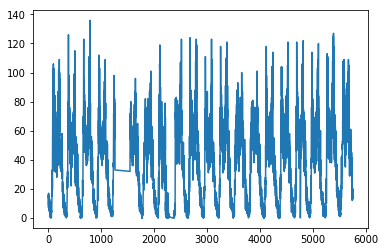

[(0.0, [2, 5, 4, 3]),
 (1.0, [6, 4, 3, 3]),
 (2.0, [2, 2, 3, 0]),
 (3.0, [1, 5, 10, 1]),
 (4.0, [1, 4, 3, 1]),
 (5.0, [0, 2, 7, 3]),
 (6.0, [1, 6, 4, 1]),
 (7.0, [1, 5, 5, 3]),
 (8.0, [1, 3, 5, 2]),
 (9.0, [0, 3, 3, 0]),
 (10.0, [2, 3, 5, 0]),
 (11.0, [0, 2, 2, 1]),
 (12.0, [0, 3, 3, 0]),
 (13.0, [0, 5, 4, 2]),
 (14.0, [3, 5, 6, 1]),
 (15.0, [1, 3, 6, 1]),
 (16.0, [4, 3, 2, 1]),
 (17.0, [0, 2, 5, 1]),
 (18.0, [0, 3, 8, 0]),
 (19.0, [0, 5, 6, 1]),
 (20.0, [0, 3, 3, 0]),
 (21.0, [0, 2, 7, 4]),
 (22.0, [0, 1, 4, 0]),
 (23.0, [0, 1, 2, 1]),
 (24.0, [0, 2, 2, 1]),
 (25.0, [0, 1, 2, 0]),
 (26.0, [0, 4, 1, 0]),
 (27.0, [0, 2, 2, 1]),
 (28.0, [0, 2, 5, 4]),
 (29.0, [0, 0, 3, 0]),
 (30.0, [0, 1, 5, 1]),
 (31.0, [0, 1, 3, 0]),
 (32.0, [0, 0, 1, 0]),
 (33.0, [0, 5, 4, 1]),
 (34.0, [0, 1, 1, 0]),
 (35.0, [0, 0, 2, 0]),
 (36.0, [0, 0, 0, 1]),
 (37.0, [0, 0, 4, 0]),
 (38.0, [0, 0, 0, 0]),
 (39.0, [0, 1, 2, 2]),
 (40.0, [0, 0, 2, 0]),
 (41.0, [0, 0, 3, 0]),
 (42.0, [0, 1, 1, 0]),
 (43.0, [0, 0, 0, 1]

In [10]:
import matplotlib.pyplot as plt
import bisect
def plotTrafficDistribution(checkPointId, timeRange=(None, None), plot=True):
    print ("running")
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    if trafficRecordsForId is None:
        print ("traffic records for id is None")
        return
    keys = [ele[0] for ele in trafficRecordsForId]
    
    startIntervalId = timeRange[0]
    endIntervalId = timeRange[1]

    startIndex = 0
    endIndex = len(trafficRecordsForId)
    
    if startIntervalId is not None:
        startIndex = bisect.bisect_left(keys, startIntervalId)
    
    if endIntervalId is not None:
        endIndex = bisect.bisect_right(keys, endIntervalId)
        
    print (plot)
    if plot:
        print ("plot")
        x, y = zip(*((ele[0], sum(ele[1])) for ele in trafficRecordsForId[startIndex: endIndex]))

        plt.plot(x, y)
        plt.show()
        
    return trafficRecordsForId[startIndex: endIndex]
    
plotTrafficDistribution("309", plot=True)    
    

In [11]:
checkMissingSpots("405")

1260.0 1544.0
2215.0 2217.0
2220.0 2222.0
2227.0 2229.0
2229.0 2231.0
2233.0 2235.0
2250.0 2252.0
2258.0 2260.0
2267.0 2270.0
2271.0 2273.0
2273.0 2275.0
2276.0 2279.0
2279.0 2291.0
2291.0 2319.0
2319.0 2344.0
2344.0 2347.0
2347.0 2356.0
2356.0 2358.0
2359.0 2378.0
2378.0 2392.0
2392.0 2395.0
2398.0 2400.0
4767.0 4773.0


In [12]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

def mape(y_true, y_pred):
    yTrueFiltered = []
    yPredFiltered = []
    
    for index, trueValue in enumerate(y_true):
        if trueValue < 5:
            continue
        yTrueFiltered.append(trueValue)
        yPredFiltered.append(y_pred[index])
        
    yTrueFiltered = np.array(yTrueFiltered)
    yPredFiltered = np.array(yPredFiltered)
    return np.mean(np.abs((yTrueFiltered - yPredFiltered) / yTrueFiltered) * 100)

def intervalToRecords(trafficRecordsForId):
    intervalToRecordsMap = {}
    for trafficRecord in trafficRecordsForId:
        intervalToRecordsMap[trafficRecord[0]] = trafficRecord[1]
    return intervalToRecordsMap

def getTrafficRecordDefaultNone(intervalToRecordsMap, intervalId, missingDataMap):
    return sum(intervalToRecordsMap.get(intervalId)) if intervalToRecordsMap.get(intervalId) is not None else missingDataMap.get(intervalId % 288)

def imputeMissingData(trafficRecordsForId):
    missingDataMap = {}
    for trafficRecord in trafficRecordsForId:
        if (trafficRecord[0] % 288) not in missingDataMap:
            missingDataMap[trafficRecord[0] % 288] = [sum(trafficRecord[1])]
        else:
            missingDataMap[trafficRecord[0] % 288].append(sum(trafficRecord[1]))
    for key, valueList in missingDataMap.items():
        missingDataMap[key] = sum(valueList) / len(valueList)
    return missingDataMap

daysLookBack = 14
splitIntervalId = 288 * 14 - 1
def createDatasetSinglePoint(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    missingDataMap = imputeMissingData(trafficRecordsForId)
    intervalToRecordsMap = intervalToRecords(trafficRecordsForId)
    X_train = []
    y_train = []
    
    X_test = []
    y_test = []
    print ("length of trafficRecordsForId", len(trafficRecordsForId))
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        timeInterval = (intervalId % (288 * 7)) // 288
        toAppend = [timeInterval]
#         for i in (0, 7):
        for i in range(daysLookBack):
            if intervalId <= splitIntervalId:
                intervalWrappedAround0 = (intervalId - i * 288 - 0) % (splitIntervalId + 1)
                intervalWrappedAround1 = (intervalId - i * 288 - 1) % (splitIntervalId + 1)
                intervalWrappedAround2 = (intervalId - i * 288 - 2) % (splitIntervalId + 1)
                intervalWrappedAround3 = (intervalId - i * 288 - 3) % (splitIntervalId + 1)
                intervalWrappedAround4 = (intervalId - i * 288 - 4) % (splitIntervalId + 1)
            else:
                intervalWrappedAround0 = (intervalId - i * 288 - 0)
                intervalWrappedAround1 = (intervalId - i * 288 - 1)
                intervalWrappedAround2 = (intervalId - i * 288 - 2)
                intervalWrappedAround3 = (intervalId - i * 288 - 3)
                intervalWrappedAround4 = (intervalId - i * 288 - 4)

            traffic1 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround1, missingDataMap)
            traffic2 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround2, missingDataMap)
            traffic3 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround3, missingDataMap)
            traffic4 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround4, missingDataMap)
            
            trafficDelta1 = (traffic1 - traffic2) if None not in (traffic1, traffic2) else None
            trafficDelta2 = (traffic2 - traffic3) if None not in (traffic2, traffic3) else None
            trafficDelta3 = (traffic3 - traffic4) if None not in (traffic3, traffic4) else None
            
            toAppend.extend([traffic1, traffic2, traffic3, traffic4, trafficDelta1, trafficDelta2, trafficDelta3])
            
            if i != 0:
                traffic0 = getTrafficRecordDefaultNone(intervalToRecordsMap, intervalWrappedAround0, missingDataMap)
                toAppend.append(traffic0)

#         print (traffic1, traffic2, traffic3)
        if None in toAppend:
            print ("toAppend", toAppend)
            continue
#         print (len(toAppend))
        if intervalId <= splitIntervalId:
            y_train.append(sum(trafficRecord[1]))
            X_train.append(toAppend)
        else:
            y_test.append(sum(trafficRecord[1]))
            X_test.append(toAppend)
    return X_train, y_train, X_test, y_test

def createDatasetWithSurroundingPoints(checkPointId, additionalPoints):
    additionalPoints.append(checkPointId)
    trafficRecords = list(map(trafficRecordsByIdLoaded.get, additionalPoints))
    intervalToRecordsMapsSurroundings = list(map(intervalToRecords, trafficRecords))
    missingDataMapsSurroundings = list(map(imputeMissingData, trafficRecords))
    print ("intervalToRecordsMapsSurroundings", len(intervalToRecordsMapsSurroundings), \
            "missingDataMapsSurroundings", len(missingDataMapsSurroundings))
    X_train = []
    y_train = []
    
    X_test = []
    y_test = []
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        timeInterval = (intervalId % (288 * 7)) // 288
        toAppend = [timeInterval]
#         for i in (0, 7):
        for i in range(daysLookBack):
            if intervalId <= splitIntervalId:
                intervalWrappedAround0 = (intervalId - i * 288 - 0) % (splitIntervalId + 1)
                intervalWrappedAround1 = (intervalId - i * 288 - 1) % (splitIntervalId + 1)
                intervalWrappedAround2 = (intervalId - i * 288 - 2) % (splitIntervalId + 1)
                intervalWrappedAround3 = (intervalId - i * 288 - 3) % (splitIntervalId + 1)
                intervalWrappedAround4 = (intervalId - i * 288 - 4) % (splitIntervalId + 1)
            else:
                intervalWrappedAround0 = (intervalId - i * 288 - 0)
                intervalWrappedAround1 = (intervalId - i * 288 - 1)
                intervalWrappedAround2 = (intervalId - i * 288 - 2)
                intervalWrappedAround3 = (intervalId - i * 288 - 3)
                intervalWrappedAround4 = (intervalId - i * 288 - 4)

            for j in range(len(intervalToRecordsMapsSurroundings)):
                intervalToRecordsMapSurroundings = intervalToRecordsMapsSurroundings[j]
                missingDataMapSurroundings = missingDataMapsSurroundings[j]

                traffic1 = getTrafficRecordDefaultNone(intervalToRecordsMapSurroundings, intervalWrappedAround1, missingDataMapSurroundings)
                traffic2 = getTrafficRecordDefaultNone(intervalToRecordsMapSurroundings, intervalWrappedAround2, missingDataMapSurroundings)
                traffic3 = getTrafficRecordDefaultNone(intervalToRecordsMapSurroundings, intervalWrappedAround3, missingDataMapSurroundings)
                traffic4 = getTrafficRecordDefaultNone(intervalToRecordsMapSurroundings, intervalWrappedAround4, missingDataMapSurroundings)

                trafficDelta1 = (traffic1 - traffic2) if None not in (traffic1, traffic2) else None
                trafficDelta2 = (traffic2 - traffic3) if None not in (traffic2, traffic3) else None
                trafficDelta3 = (traffic3 - traffic4) if None not in (traffic3, traffic4) else None

                toAppend.extend([traffic1, traffic2, traffic3, traffic4, trafficDelta1, trafficDelta2, trafficDelta3])
            
                if i != 0:
                    traffic0 = getTrafficRecordDefaultNone(intervalToRecordsMapSurroundings, intervalWrappedAround0, missingDataMapSurroundings)
                    toAppend.append(traffic0)

#         print (traffic1, traffic2, traffic3)
        if None in toAppend:
            print ("toAppend", toAppend)
            continue
#         print (len(toAppend))
        if intervalId <= splitIntervalId:
            y_train.append(sum(trafficRecord[1]))
            X_train.append(toAppend)
        else:
            y_test.append(sum(trafficRecord[1]))
            X_test.append(toAppend)
    return X_train, y_train, X_test, y_test

def gbm(checkPointId, additionalPoints):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    X_train, y_train, X_test, y_test = createDatasetWithSurroundingPoints(checkPointId, additionalPoints)
    print ("Length of X_train", len(X_train), "Length of X_test", len(X_test))
#     print (y_train)
#     splitPoint = len(trafficRecordsForId) // 10 * 8
#     X_train, X_test = X[:splitPoint], X[splitPoint:]
#     y_train, y_test = y[:splitPoint], y[splitPoint:]
    est = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
        max_depth=5, loss='ls').fit(X_train, y_train)
    print (mape(y_test, est.predict(X_test)))
    print (mean_squared_error(y_test, est.predict(X_test)))
    
gbm("405", ["513", "705"])


intervalToRecordsMapsSurroundings 3 missingDataMapsSurroundings 3
Length of X_train 3629 Length of X_test 1723
12.6044349668
177.433981345


trafficRecordsForId[-1][0] 5759.0
dataset.shape (5759, 1)
Epoch 1/1
81s - loss: 0.0145
Epoch 1/1
79s - loss: 0.0107
Epoch 1/1
78s - loss: 0.0091
Epoch 1/1
77s - loss: 0.0082
Epoch 1/1
81s - loss: 0.0078
Epoch 1/1
87s - loss: 0.0075
Epoch 1/1
86s - loss: 0.0074
Epoch 1/1
84s - loss: 0.0073
Epoch 1/1
85s - loss: 0.0072
Epoch 1/1
79s - loss: 0.0072
Epoch 1/1
79s - loss: 0.0071
Epoch 1/1
79s - loss: 0.0070
Epoch 1/1
79s - loss: 0.0069
Epoch 1/1
79s - loss: 0.0068
Epoch 1/1
79s - loss: 0.0067
Epoch 1/1
81s - loss: 0.0067
Epoch 1/1
78s - loss: 0.0067
Epoch 1/1
78s - loss: 0.0067
Epoch 1/1
77s - loss: 0.0067
Epoch 1/1
78s - loss: 0.0067
Epoch 1/1
78s - loss: 0.0067
Epoch 1/1
80s - loss: 0.0068
Epoch 1/1
80s - loss: 0.0068
Epoch 1/1
81s - loss: 0.0072
Epoch 1/1
79s - loss: 0.0067
Epoch 1/1
79s - loss: 0.0066
Epoch 1/1
79s - loss: 0.0066
Epoch 1/1
79s - loss: 0.0067
Epoch 1/1
79s - loss: 0.0067
Epoch 1/1
79s - loss: 0.0086
Epoch 1/1
79s - loss: 0.0073
Epoch 1/1
79s - loss: 0.0072
Epoch 1/1
79s 

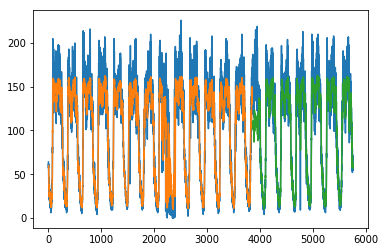

In [19]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
# load the dataset
# dataframe = read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
# dataset = dataframe.values
dataset = []
trafficRecordsForId = trafficRecordsByIdLoaded.get("405")
missingDataMap = imputeMissingData(trafficRecordsForId)
intervalToRecordsMap = intervalToRecords(trafficRecordsForId)
print ("trafficRecordsForId[-1][0]", trafficRecordsForId[-1][0])
for i in range(int(trafficRecordsForId[-1][0])):
    record = getTrafficRecordDefaultNone(intervalToRecordsMap, i, missingDataMap)
    if record is None:
        continue
    dataset.append([record])
dataset = np.array(dataset)
print ("dataset.shape", dataset.shape)
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
# print (trainX)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print ('MAPE: ', mape(testY[0], testPredict[:,0]))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()